# Imports


In [ ]:
import torch
import torchvision

import math

import numpy as np

from matplotlib.pyplot import imshow

from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Compose, RandomRotation, RandomHorizontalFlip, RandomCrop, Normalize
from torchvision.transforms.functional import pil_to_tensor
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.nn as nn
import torch.nn.functional as F
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data

In [ ]:
# Download CIFAR-10 IF NOT ALREADY EXISTS
train = CIFAR10("/cifardata", transform=Compose([ToTensor(), 
                                                 Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])]), download=True, train=True) # We transform the data to tensors
transformed_train = CIFAR10("/cifardata", transform=Compose([ToTensor(),
                                                             RandomCrop(32, 4, padding_mode="reflect"), 
                                                             RandomHorizontalFlip(), 
                                                             Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])]), train=True)

test = CIFAR10("/cifardata", transform=Compose([ToTensor(), 
                                                Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])]), download=True, train=False) # Once downloaded.

def get_train_loader(batch_size:int = 32):
  return DataLoader(transformed_train, batch_size=batch_size, shuffle=True, drop_last=True)

def get_test_loader(batch_size=1):
  return DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=False)



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /cifardata/cifar-10-python.tar.gz to /cifardata
Files already downloaded and verified


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)



In [ ]:
device = get_default_device()

# Model

In [ ]:
class CIFAR10Layers(nn.Module):
  def __init__(self, channel_in, channel_out, downsample: bool = False):
    super(CIFAR10Layers, self).__init__()
    self.identity_map = nn.Sequential()

    self.conv1 = nn.Conv2d(channel_in, channel_out, kernel_size=(3,3), stride=1, padding=1)
    self.conv2 = nn.Conv2d(channel_out, channel_out, kernel_size=(3,3), stride=1, padding=1)

    self.bnorm1 = nn.BatchNorm2d(channel_out)
    self.bnorm2 = nn.BatchNorm2d(channel_out)

    if downsample:
      self.conv1 = nn.Conv2d(channel_in, channel_out, kernel_size=(3,3), stride=2, padding=1)
      self.identity_map = nn.Sequential(
          nn.Conv2d(channel_in, channel_out, kernel_size=(1,1), stride=2, padding=0),
          nn.BatchNorm2d(channel_out)
      )


  def forward(self, x):
    res = F.relu(self.bnorm1(self.conv1(x)))
    res = F.relu(self.bnorm2(self.conv2(res)))
    return F.relu(res + self.identity_map(x))


class ResidualNetCifar10(nn.Module):
  """ResNet for CIFAR10
      As described in section 4.2 in https://arxiv.org/pdf/1512.03385.pdf

  """
  def __init__(self):
    super(ResidualNetCifar10, self).__init__()

    self.conv = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = (3,3), stride=1, padding=1)
  
    self.l11 = CIFAR10Layers(16, 16, downsample=False)
    self.l12 = CIFAR10Layers(16, 16, downsample=False)
    self.l13 = CIFAR10Layers(16, 16, downsample=False)
    self.l21 = CIFAR10Layers(16, 32, downsample=True)
    self.l22 = CIFAR10Layers(32, 32, downsample=False)
    self.l23 = CIFAR10Layers(32, 32, downsample=False)
    self.l31 = CIFAR10Layers(32, 64, downsample=True)
    self.l32 = CIFAR10Layers(64, 64, downsample=False)
    self.l33 = CIFAR10Layers(64, 64, downsample=False)

    self.avgpool = nn.AdaptiveAvgPool2d(1)
    self.flatten = nn.Flatten()
    self.linear = nn.LazyLinear(out_features=10)

  def forward(self, x):

    res = F.relu(self.conv(x))

    res = self.l11(res)
    res = self.l12(res)
    res = self.l13(res)
    res = self.l21(res)
    res = self.l22(res)
    res = self.l23(res)
    res = self.l31(res)
    res = self.l32(res)
    res = self.l33(res)

    res = self.avgpool(res)

    res = self.flatten(res)
    res = self.linear(res)
    return res

CifarResNet = ResidualNetCifar10()
#CifarResNet

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


# Training

In [ ]:
def val_step(test_loader):
  val_loss = 0
  for val, targ in iter(test_loader):
    val_loss += loss.sum().item()
  return val_loss


def accuracy(model, test_loader):
  wrong, correct = 0, 0
  for val, targ in iter(test_loader):
    model_val = model(val)
    for v, t in zip(model_val, targ):
      if torch.argmax(v).item() == t.item():
        correct += 1
      else:
        wrong += 1
  print(f"\tTest Accuracy: {correct/(correct+wrong)}")
  return correct/(correct+wrong)

def save_data(filename: str, train_loss, val_loss, val_acc):
  """Do not include '.txt' in the filename!
  """
  PATH="/content/drive/MyDrive/DL/"
  with open(f"{PATH}{filename}-train-loss.txt", "w") as file:
   data = " ".join([str(x) for x in train_loss])
   file.write(data)
  with open(f"{PATH}{filename}-validation-loss.txt", "w") as file:
   data = " ".join([str(x) for x in val_loss])
   file.write(data)
  with open(f"{PATH}{filename}-validation-accuracy.txt", "w") as file:
   data = " ".join(str(x) for x in val_acc)
   file.write(data)

def load_data(filename: str):
  PATH="/content/drive/MyDrive/DL/"
  with open(f"{PATH}{filename}-train-loss.txt") as file:
    train_losses = [float(x) for x in file.readlines()[0].split(" ")]
  with open(f"{PATH}{filename}-validation-loss.txt") as file:
    val_losses = [float(x) for x in file.readlines()[0].split(" ")]
  with open(f"{PATH}{filename}-validation-accuracy.txt") as file:
    val_accuracies = [float(x) for x in file.readlines()[0].split(" ")]
  return train_losses, val_losses, val_accuracies

In [ ]:
# Define neccessary variables
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
epochs = 100
batch_size = 128

newModel = True
saveModel = False
loadModel = False

model_name = "ResNetCIFAR10"

if newModel:
  model = ResidualNetCifar10()

model.to(device) 

if loadModel:
  model.load_state_dict(torch.load(f"/content/drive/MyDrive/DL/{new_model}_params.pt"))
else:
  # DATA LOADERS
  train_loader = DeviceDataLoader(get_train_loader(batch_size), device)
  test_loader = DeviceDataLoader(get_test_loader(batch_size*2), device)
  # OPTIMIZER & LOSS FUNCTION
  loss_function = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[32e3,48e3], gamma=0.1, verbose=False)

  # Epoch End Loss
  val_losses = []
  train_losses = []
  val_accuracies = []

  for epoch in range(epochs):
    print(f"----- EPOCH {epoch + 1} -----")

    running_loss = 0
    model.train()

    for batch, (vals, real_targs) in enumerate(iter(train_loader)):
      model_targs = model(vals)

      # zero grad the optimizer
      optimizer.zero_grad()

      # calculate loss
      loss = loss_function(model_targs, real_targs)
      running_loss += loss.item()
      # Backpropogate loss
      loss.backward()

      # Step optimizer
      optimizer.step()
      scheduler.step()

    print(f"\tEpoch Loss: {running_loss:.2f}")
    print(f"----- END OF EPOCH {epoch + 1} : RUNNING VAL TEST -----")

    model.eval()
    train_losses.append(running_loss)
    val_losses.append(val_step(test_loader))
    val_accuracies.append(accuracy(model, test_loader))
    running_loss = 0
  print(f"DONE!")
  

----- EPOCH 1 -----
	Epoch Loss: 696.07
----- END OF EPOCH 1 : RUNNING VAL TEST -----
	Test Accuracy: 0.4558
----- EPOCH 2 -----
	Epoch Loss: 496.50
----- END OF EPOCH 2 : RUNNING VAL TEST -----
	Test Accuracy: 0.6308
----- EPOCH 3 -----
	Epoch Loss: 383.47
----- END OF EPOCH 3 : RUNNING VAL TEST -----
	Test Accuracy: 0.644
----- EPOCH 4 -----
	Epoch Loss: 314.80
----- END OF EPOCH 4 : RUNNING VAL TEST -----
	Test Accuracy: 0.742
----- EPOCH 5 -----
	Epoch Loss: 276.59
----- END OF EPOCH 5 : RUNNING VAL TEST -----
	Test Accuracy: 0.7154
----- EPOCH 6 -----
	Epoch Loss: 250.49
----- END OF EPOCH 6 : RUNNING VAL TEST -----
	Test Accuracy: 0.6959
----- EPOCH 7 -----
	Epoch Loss: 230.78
----- END OF EPOCH 7 : RUNNING VAL TEST -----
	Test Accuracy: 0.7792
----- EPOCH 8 -----
	Epoch Loss: 216.28
----- END OF EPOCH 8 : RUNNING VAL TEST -----
	Test Accuracy: 0.7878
----- EPOCH 9 -----
	Epoch Loss: 204.39
----- END OF EPOCH 9 : RUNNING VAL TEST -----
	Test Accuracy: 0.7817
----- EPOCH 10 -----


In [ ]:
torch.save(model.state_dict(), f"/content/drive/MyDrive/DL/{model_name}_params.pt")
save_data(model_name, train_losses, val_losses, val_accuracies)

# Plot & Statistic Functions

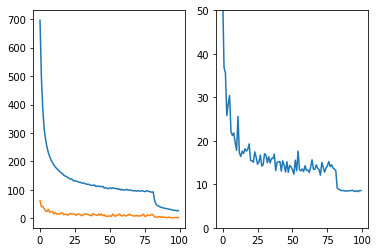

In [ ]:
def plot_losses_and_accuracy(tl, vl, va, show_acc_as_error: bool = False):
  figure, axis = plt.subplots(1, 2)
  axis[0].plot(tl)
  axis[0].plot(vl)
  if show_acc_as_error:
    axis[1].plot([(1-a)*100.0 for a in va])
  else:
    axis[1].plot(va)
  axis[1].set_ylim((0, 50))

plot_losses_and_accuracy(*(load_data(model_name)), True)